Vamos a intentar reconstruir el período (`PeriodLS`) de una estrella RRLyrae usando procesos gaussianos.

# Código Auxiliar

## Imports
Pongo los imports acá porque no discutimos organización de código.

In [33]:
import carpyncho
import feets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PyAstronomy.pyasl import foldAt
from sklearn.gaussian_process import GaussianProcessRegressor

## Funciones auxiliares
Defino funciones auxiliares que no sé dónde van porque no discutimos organización de código.

### Manipulación de curvas de luz

In [34]:
# Auxiliary functions for light curve manipulation.

# Given a light curve, reorders the points by the given period.
# If no period is given, it is calculated using Lomb-Scargle.
def make_periodical(light_curve, period=None):
    lc = light_curve.sort_values("pwp_stack_src_mag3")

    # split in time, magnitude and error
    time, mag, err = (
            lc.pwp_stack_src_hjd.values,
            lc.pwp_stack_src_mag3.values,
            lc.pwp_stack_src_mag_err3.values)

    # t0 is the time with the lowest magnitude
    t0 = time[0]

    # TODO: Y Period_fit?
    if period is None:
        fs = feets.FeatureSpace(only=['PeriodLS', 'Period_fit'])
        _, values = fs.extract(time, mag, err)
        period = values[0]

    # fold
    phases = foldAt(time, period, T0=t0)
    sort = np.argsort(phases)
    phases, pmag, perr = phases[sort], mag[sort], err[sort]

    lc = pd.DataFrame(data={'pmag': pmag, 'phases': phases, 'perr': perr})

    return lc, period

# Given a periodic light curve, uses Lomb-Scargle to recalculate the period
# and rearranges the points using the new period.
def recalculate_period(light_curve):
    # t0 is the time with the lowest magnitude
    lc = light_curve.sort_values("pmag")
    t0 = lc.phases[0]

    # TODO: Y Period_fit?
    fs = feets.FeatureSpace(only=['PeriodLS', 'Period_fit'])
    features, values = fs.extract(lc.phases, lc.pmag, lc.perr)
    period = values[0]


    # get new period
    phases = foldAt(lc.phases, period, T0=t0)
    sort = np.argsort(phases)
    phases, pmag, perr = phases[sort], lc.pmag[sort], lc.perr[sort]

    lc = pd.DataFrame(data={'pmag': pmag, 'phases': phases, 'perr': perr})
    return lc, values[0], values[1]

# Given a periodic light curve, uses a gaussian process regressor to add
# n_synthetic points at random phase values.
def generate_points(period_lc, n_synthetic):
    # split in time, magnitude and error
    phases, pmag, perr = (
            period_lc.phases.values,
            period_lc.pmag.values,
            period_lc.perr.values)

    #TODO: Y el error? Por ahora le puse la media de los errores.
    model = GaussianProcessRegressor()
    model.fit(period_lc[['phases']], period_lc['pmag'])
    synthetic_phases = np.random.rand(n_synthetic)
    synthetic_mag = model.sample_y(synthetic_phases.reshape(-1, 1))
    synthetic_err = np.full(n_synthetic, np.average(perr))

    pmag = np.append(pmag, np.ndarray.flatten(synthetic_mag))
    phases = np.append(phases, synthetic_phases)
    perr = np.append(perr, synthetic_err)

    lc = pd.DataFrame(data={'pmag': pmag, 'phases': phases, 'perr': perr})

    return lc

### Graficación

In [35]:
# Auxiliary plotting functions.

# Given a light curve, plots magnitude vs HJD.
def plot_chronological(star, light_curve):
    light_curve = light_curve.sort_values("pwp_stack_src_hjd")

    fig, ax = plt.subplots(figsize=(12, 4))

    ax.errorbar(
        light_curve.pwp_stack_src_hjd,
        light_curve.pwp_stack_src_mag3,
        light_curve.pwp_stack_src_mag_err3,
        ls="", marker="o", color="tab:blue", ecolor="tab:red")

    ax.set_title(f"Light Curve of source {star.id}")
    ax.set_ylabel("Magnitude")
    ax.set_xlabel("HJD")

    ax.invert_yaxis()
    fig.tight_layout()

# Given a periodical light curve, plots magnitude vs period in two phases.
def plot_periodical(period_lc):
    # split in time, magnitude and error
    phases, pmag, perr = (
            period_lc.phases.values,
            period_lc.pmag.values,
            period_lc.perr.values)

    # duplicate the values in two phases
    phases = np.hstack((phases, phases + 1))
    pmag = np.hstack((pmag, pmag))
    perr = np.hstack((perr, perr))

    # plot the folded light curve
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.errorbar(phases, pmag, perr, ls="", marker="o", ecolor="tab:blue", color="tab:red")
    ax.set_title(f"Folded Light Curve of source ???")
    ax.set_ylabel("Magnitude")
    ax.set_xlabel("Phase")
    ax.invert_yaxis()

    fig.tight_layout()

# Reconstrucción de Período

## Obtención de los datos
Primero descargamos el tile `b214` y elegimos una estrella periódica clasificada (o sea con `vs_type` no vacío) con máxima cantidad de observaciones.

In [36]:
# Instance the client and get the b214 tile catalogs.
client = carpyncho.Carpyncho()
b214_lc = client.get_catalog("b214", "lc")
b214_features = client.get_catalog("b214", "features")

In [37]:
# Find a classified variable star with maximum amount of observations.
b214_features['vs_type'].replace('', np.nan, inplace=True)
b214_features = b214_features[b214_features["vs_type"].notna()]
star = b214_features.loc[b214_features["cnt"].idxmax()]
star

id              32140000002913
cnt                         68
ra_k                280.582129
dec_k               -25.299033
vs_type             RRLyr-RRab
                     ...      
n09_jh_color          0.123061
n09_jk_color          0.163291
n09_m2                13.89353
n09_m4               13.895081
ppmb                  1.629816
Name: 4456, Length: 73, dtype: object

Nos tocó justo una RRLyrae. Qué bien. Nos traemos entonces la curva de luz.

In [38]:
# Get the observations for the star.
light_curve = b214_lc[b214_lc.bm_src_id == star.id]

Graficamos la magnitud respecto de la fecha de la observación.

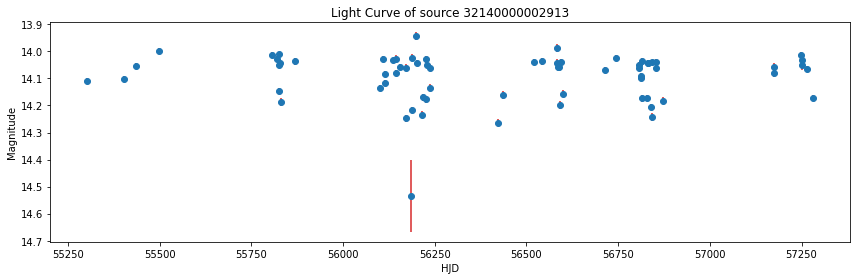

In [39]:
plot_chronological(star, light_curve)

Graficamos la magnitud respecto del período que indica `PeriodLS` en el catálogo.

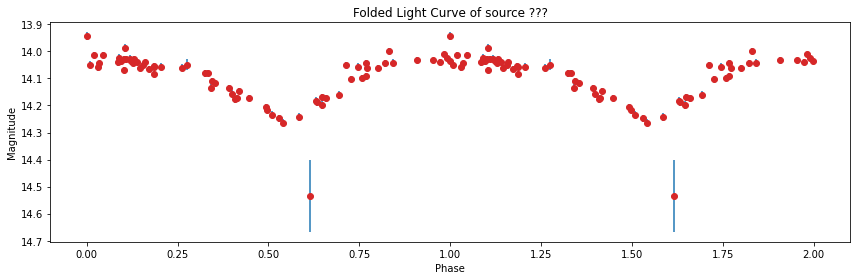

In [40]:
period_lc, _ = make_periodical(light_curve, star.PeriodLS)
plot_periodical(period_lc)

Veamos cuál es el período.

In [41]:
star.PeriodLS

0.5798141360636985

## Reconstrucción del período
Ahora el experimento. Vamos a elegir `n_sample` puntos de la curva de luz al azar y vamos a poner esos puntos en fase usando Lomb-Scargle. Luego vamos a hacer `n_iter` veces lo siguiente:
* Entrenar un proceso gaussiano con los puntos.
* Utilizarlo para agregar `n_synthetic` puntos que se encuentran en un valor al azar (uniformemente distribuido) de la fase.
* Utilizar todos los puntos para recalcular el período usando Lomb-Scargle.
  
Queremos ver si logramos acercarnos al período del catálogo.

In [42]:
# Parameters.
n_sample = 40
n_iter = 10
n_synthetic = 2

In [43]:
%%capture
# TODO: La linea de arriba es porque se me enoja astropy con un deprecation warning que no importa ahora.
period_ls_list = []
period_fit_list = []

original_sample = light_curve.sample(n=n_sample)
synthetic_lc, period_ls = make_periodical(original_sample)
period_ls_list.append(period_ls)

for _ in range(n_iter):
    synthetic_lc = generate_points(synthetic_lc, n_synthetic)
    synthetic_lc, period_ls, period_fit = recalculate_period(synthetic_lc)
    period_ls_list.append(period_ls)
    period_fit_list.append(period_fit)

## Resultados

A ver el período que calculó en cada paso...

In [44]:
period_ls_list

[1.3853064136985709,
 0.9041954081451629,
 1.1012524543255235,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0939998083547555,
 1.0000000000000004]

Da horrible... no sé si me da paz o no que se estabilice.

In [45]:
period_fit_list

[6.767146842889815e-10,
 5.4203863619761705e-11,
 2.9923841182721844e-12,
 5.25135490647699e-13,
 1.9206858326015208e-14,
 1.9984014443252818e-15,
 0.0,
 0.0,
 7.091823683857967e-09,
 1.2209298017040737e-09]

A la vez vemos que cada vez estamos más convencidos del período que obtenemos (qué mal).

Y si graficamos los puntos queda algo nada que ver (obvio, porque el período no tiene nada que ver con el original).

60

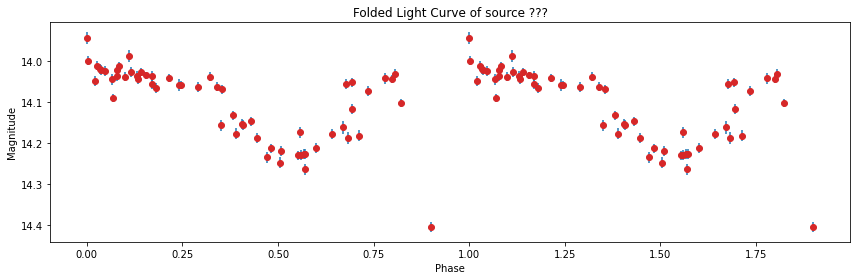

In [46]:
plot_periodical(synthetic_lc)
len(synthetic_lc)